In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Blinkit Data.csv"
df = pd.read_csv(file_path)

# Display original data info
print("Original Data Summary:")
print(f"Shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Drop unnecessary 'Unnamed' columns
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
if unnamed_cols:
    print(f"\nRemoving {len(unnamed_cols)} unnamed columns: {unnamed_cols}")
    df = df.drop(columns=unnamed_cols)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Replace empty strings with NaN
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('', np.nan)

# Fill missing values
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
        print(f"Filled {col} NaN values with median: {median_value}")

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)
        print(f"Filled {col} NaN values with mode: {mode_value}")

# Extract time features
df['year'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Keep original values before transformation
df['qty_sold_orig'] = df['qty_sold'].copy()
df['mrp_orig'] = df['mrp'].copy()

# Encode categorical features
label_encoders = {}
categorical_columns = ['city_name', 'category', 'item_name']

for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Create scaled versions using different methods
# 1. Standard Scaler (mean=0, std=1)
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(df[['qty_sold', 'mrp']])
df['qty_sold_std'] = std_scaled[:, 0]
df['mrp_std'] = std_scaled[:, 1]

# 2. MinMax Scaler [0,1]
mm_scaler = MinMaxScaler()
mm_scaled = mm_scaler.fit_transform(df[['qty_sold', 'mrp']])
df['qty_sold_minmax'] = mm_scaled[:, 0]
df['mrp_minmax'] = mm_scaled[:, 1]

# 3. Log transform then scale
df['qty_sold_log'] = np.log1p(df['qty_sold'])
df['mrp_log'] = np.log1p(df['mrp'])

log_mm_scaler = MinMaxScaler()
log_scaled = log_mm_scaler.fit_transform(df[['qty_sold_log', 'mrp_log']])
df['qty_sold_log_minmax'] = log_scaled[:, 0]
df['mrp_log_minmax'] = log_scaled[:, 1]

# Feature Engineering
# Create revenue feature
df['revenue'] = df['qty_sold'] * df['mrp']

# Create derived features
df['price_tier'] = pd.qcut(df['mrp'], q=4, labels=['Low', 'Medium', 'High', 'Premium'])
df['order_size'] = pd.qcut(df['qty_sold'], q=3, labels=['Small', 'Medium', 'Large'])

# Create day-of-week name for better readability
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['day_name'] = df['weekday'].map(days)

# Show the cleaned and processed dataframe
print("\nCleaned and processed dataframe (first 5 rows):")
selected_cols = ['date', 'city_name', 'item_name', 'qty_sold', 'mrp', 'revenue',
                'day_name', 'is_weekend', 'qty_sold_std', 'mrp_std']
print(df[selected_cols].head())

# Verification of scaling
print("\nVerification of scaling methods:")
scaling_cols = ['qty_sold', 'qty_sold_std', 'qty_sold_minmax', 'qty_sold_log_minmax']
print(df[scaling_cols].describe().round(3))

# Summary statistics by city
city_summary = df.groupby('city_name').agg({
    'qty_sold': ['sum', 'mean'],
    'revenue': ['sum', 'mean'],
    'item_id': 'nunique'
}).reset_index()
city_summary.columns = ['city_name', 'total_qty', 'avg_qty', 'total_revenue', 'avg_revenue', 'unique_items']
print("\nTop cities by revenue:")
print(city_summary.sort_values('total_revenue', ascending=False).head())

# Save the cleaned and processed data
df.to_csv("blinkit_data_cleaned.csv", index=False)
print("\nCleaned and processed data saved as blinkit_data_cleaned.csv")

Original Data Summary:
Shape: (2668, 10)

Column names:
['date', 'Month', 'city_name', 'category', 'item_id', 'item_name', 'qty_sold', 'mrp', 'Unnamed: 8', 'Unnamed: 9']

Removing 2 unnamed columns: ['Unnamed: 8', 'Unnamed: 9']

Missing values before cleaning:
date         0
Month        0
city_name    0
category     0
item_id      0
item_name    0
qty_sold     0
mrp          0
dtype: int64
Encoded city_name: 15 unique values
Encoded category: 1 unique values
Encoded item_name: 4 unique values

Cleaned and processed dataframe (first 5 rows):
        date   city_name                         item_name  qty_sold   mrp  \
0 2023-10-02      Meerut  Jivo Cold Press Canola Oil (5 l)         1  1650   
1 2023-10-28  Chandigarh        Jivo Cold Press Canola Oil         1   375   
2 2023-12-29      Mohali  Jivo Cold Press Canola Oil (5 l)         1  1650   
3 2023-11-27    Zirakpur  Jivo Cold Press Canola Oil (5 l)         1  1650   
4 2023-10-05    Ludhiana        Jivo Cold Press Canola Oil    

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = "/content/blinkit_data_cleaned.csv"
df = pd.read_csv(file_path)

print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")

# Check if encoding is needed
# Examine if the columns are already encoded
print("\nChecking if columns need encoding:")
categorical_cols = ['city_name', 'category', 'item_name']
for col in categorical_cols:
    # Check if the column contains string data (needs encoding)
    if df[col].dtype == 'object':
        print(f"✓ Column '{col}' needs encoding (contains string data)")
        unique_values = df[col].nunique()
        print(f"  - Contains {unique_values} unique values")
    else:
        print(f"✗ Column '{col}' is already numeric (no encoding needed)")

# Check if there are already encoded versions of these columns
for col in categorical_cols:
    encoded_col = f"{col}_encoded"
    if encoded_col in df.columns:
        print(f"✓ Column '{encoded_col}' already exists")
        # We'll use this column instead of re-encoding

        # Check if we need to remove the original string column for memory efficiency
        if df[col].dtype == 'object':
            print(f"  - Consider dropping original '{col}' column to save memory")
    else:
        print(f"✗ No encoded version found for '{col}'")

# Encode only if needed (if no encoded version exists)
label_encoders = {}
for col in categorical_cols:
    encoded_col = f"{col}_encoded"

    # If we don't have an encoded version and the column is string type
    if encoded_col not in df.columns and df[col].dtype == 'object':
        print(f"\nEncoding '{col}'...")
        le = LabelEncoder()
        df[encoded_col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"  - Created new column '{encoded_col}'")
    elif encoded_col in df.columns:
        # We have an encoded version, use it directly
        print(f"\nUsing existing encoded column '{encoded_col}'")
    else:
        # The column is already numeric
        print(f"\nColumn '{col}' is already numeric, no encoding needed")

# Convert date to datetime if it's not already
if df['date'].dtype != 'datetime64[ns]':
    df['date'] = pd.to_datetime(df['date'])
    print("\nConverted 'date' column to datetime format")

# Ensure all necessary date features exist
date_features = {
    'year': lambda x: x.dt.year,
    'month_num': lambda x: x.dt.month,
    'day': lambda x: x.dt.day,
    'weekday': lambda x: x.dt.dayofweek,
    'is_weekend': lambda x: (x.dt.dayofweek >= 5).astype(int)
}

for feat_name, feat_func in date_features.items():
    if feat_name not in df.columns:
        df[feat_name] = feat_func(df['date'])
        print(f"Added missing date feature: {feat_name}")

# Create mapping for feature analysis
print("\nPreparing for analysis...")
# Use either original or encoded columns based on what's available
city_col = 'city_name_encoded' if 'city_name_encoded' in df.columns else 'city_name'
item_col = 'item_name_encoded' if 'item_name_encoded' in df.columns else 'item_name'

# Create a mapping dictionary for city names and ids
city_mapping = {}
if 'city_name_encoded' in df.columns and df['city_name'].dtype == 'object':
    city_mapping = dict(zip(df['city_name_encoded'], df['city_name']))
    print(f"Created mapping for {len(city_mapping)} cities")

# Save processed dataset
output_path = "/content/processed_data.csv"
df.to_csv(output_path, index=False)
print(f"\nDataset processed and saved as {output_path}")

# Display the first few rows with key columns
important_cols = ['date', city_col, item_col, 'qty_sold', 'mrp', 'revenue']
print("\nFirst 5 rows of processed data:")
print(df[important_cols].head())

# Quick data analysis - Top selling cities
if 'city_name' in df.columns:
    top_cities = df.groupby('city_name').agg({
        'qty_sold': 'sum',
        'revenue': 'sum'
    }).sort_values('revenue', ascending=False).head(10)

    print("\nTop 10 cities by revenue:")
    print(top_cities)

Loaded dataset with 2668 rows and 30 columns

Checking if columns need encoding:
✓ Column 'city_name' needs encoding (contains string data)
  - Contains 15 unique values
✓ Column 'category' needs encoding (contains string data)
  - Contains 1 unique values
✓ Column 'item_name' needs encoding (contains string data)
  - Contains 4 unique values
✓ Column 'city_name_encoded' already exists
  - Consider dropping original 'city_name' column to save memory
✓ Column 'category_encoded' already exists
  - Consider dropping original 'category' column to save memory
✓ Column 'item_name_encoded' already exists
  - Consider dropping original 'item_name' column to save memory

Using existing encoded column 'city_name_encoded'

Using existing encoded column 'category_encoded'

Using existing encoded column 'item_name_encoded'

Converted 'date' column to datetime format

Preparing for analysis...
Created mapping for 15 cities

Dataset processed and saved as /content/processed_data.csv

First 5 rows of 

Data before normalization:
qty_sold range: 1 to 959
mrp range: 0 to 93980
Total rows: 2668

After RobustScaler:
qty_sold_robust range: -0.3333 to 106.1111
mrp_robust range: -0.3586 to 10.3513
revenue_robust range: -0.1197 to 59.9942

No rows with qty_sold = 0 found
Found 675 rows with qty_sold <= 1
Sample of how low values were handled:
   qty_sold   mrp  revenue
0         1  1650     1650
1         1   375      375
2         1  1650     1650
3         1  1650     1650
6         1   375      375

After scaling:
   qty_sold       mrp   revenue
0 -0.333333 -0.170598 -0.098616
1 -0.333333 -0.315897 -0.114893
2 -0.333333 -0.170598 -0.098616
3 -0.333333 -0.170598 -0.098616
6 -0.333333 -0.315897 -0.114893


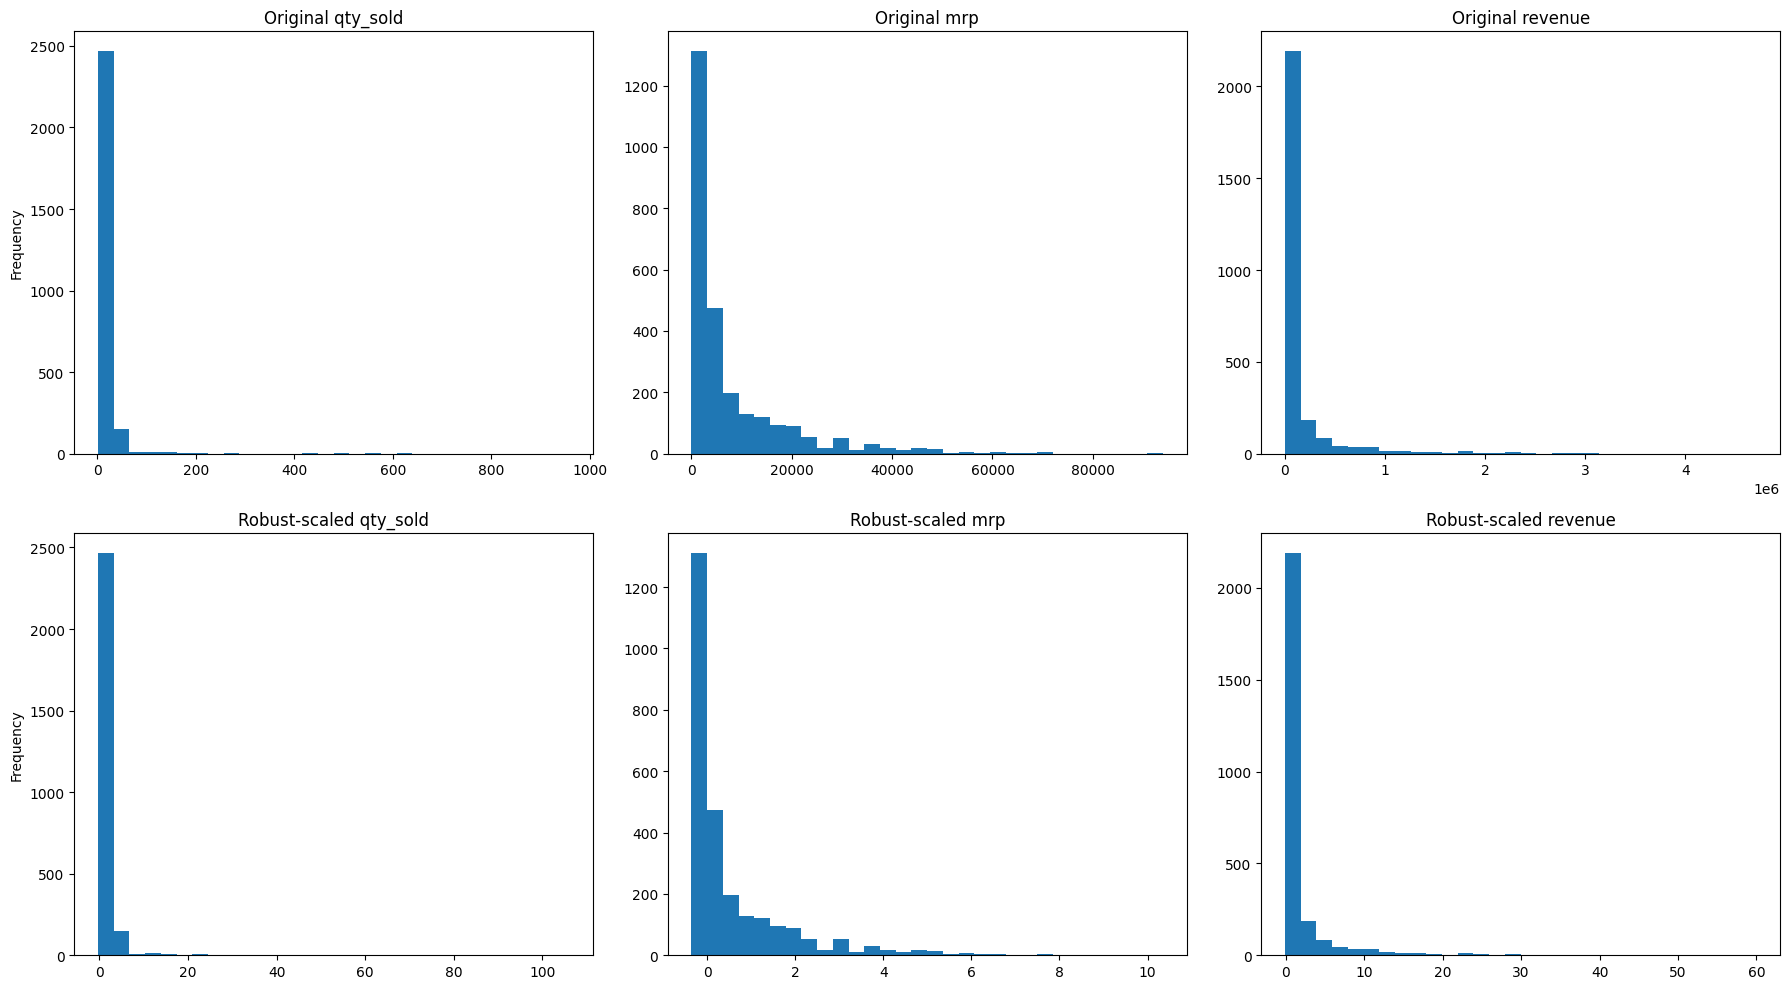


Data normalized with RobustScaler and saved as robust_normalized_data.csv

First few rows of robustly scaled data:


,date,city_name_encoded,item_name_encoded,qty_sold,mrp,revenue
0,2023-10-02,11,1,-0.333333,-0.170598,-0.098616
1,2023-10-28,2,0,-0.333333,-0.315897,-0.114893
2,2023-12-29,12,1,-0.333333,-0.170598,-0.098616
3,2023-11-27,14,1,-0.333333,-0.170598,-0.098616
4,2023-10-05,10,0,0.222222,-0.102222,0.052659


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/processed_data.csv"
df = pd.read_csv(file_path)

# Print info about data before normalization
print("Data before normalization:")
print(f"qty_sold range: {df['qty_sold'].min()} to {df['qty_sold'].max()}")
print(f"mrp range: {df['mrp'].min()} to {df['mrp'].max()}")
print(f"Total rows: {len(df)}")

# Apply RobustScaler to numerical columns
robust_scaler = RobustScaler()
num_cols = ['qty_sold', 'mrp', 'revenue']
df_scaled = df.copy()
df_scaled[num_cols] = robust_scaler.fit_transform(df[num_cols])

# Check the scaling results
print("\nAfter RobustScaler:")
print(f"qty_sold_robust range: {df_scaled['qty_sold'].min():.4f} to {df_scaled['qty_sold'].max():.4f}")
print(f"mrp_robust range: {df_scaled['mrp'].min():.4f} to {df_scaled['mrp'].max():.4f}")
print(f"revenue_robust range: {df_scaled['revenue'].min():.4f} to {df_scaled['revenue'].max():.4f}")

# Compare original zeros with their scaled versions
zero_qty_rows = df[df['qty_sold'] == 0].index
if len(zero_qty_rows) > 0:
    print(f"\nFound {len(zero_qty_rows)} rows with qty_sold = 0")
    print("Sample of how zeros were handled:")
    print(df_scaled.loc[zero_qty_rows[:5], num_cols].head())
else:
    print("\nNo rows with qty_sold = 0 found")

    # Show low value examples instead
    low_qty_rows = df[df['qty_sold'] <= 1].index
    print(f"Found {len(low_qty_rows)} rows with qty_sold <= 1")
    print("Sample of how low values were handled:")
    print(df.loc[low_qty_rows[:5], ['qty_sold', 'mrp', 'revenue']].head())
    print("\nAfter scaling:")
    print(df_scaled.loc[low_qty_rows[:5], num_cols].head())

# Visualize the distribution before and after scaling
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original distributions
axes[0, 0].hist(df['qty_sold'], bins=30)
axes[0, 0].set_title('Original qty_sold')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['mrp'], bins=30)
axes[0, 1].set_title('Original mrp')

axes[0, 2].hist(df['revenue'], bins=30)
axes[0, 2].set_title('Original revenue')

# Scaled distributions
axes[1, 0].hist(df_scaled['qty_sold'], bins=30)
axes[1, 0].set_title('Robust-scaled qty_sold')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_scaled['mrp'], bins=30)
axes[1, 1].set_title('Robust-scaled mrp')

axes[1, 2].hist(df_scaled['revenue'], bins=30)
axes[1, 2].set_title('Robust-scaled revenue')

plt.tight_layout()
plt.savefig('robust_scaling_comparison.png')
plt.show()

# Save the processed data
df_scaled.to_csv("/content/robust_normalized_data.csv", index=False)
print("\nData normalized with RobustScaler and saved as robust_normalized_data.csv")

# Show first few rows
print("\nFirst few rows of robustly scaled data:")
display(df_scaled[['date', 'city_name_encoded', 'item_name_encoded'] + num_cols].head())

In [ ]:
# Import necessary libraries
import pandas as pd

# Load dataset
file_path = "/content/robust_normalized_data.csv"
df = pd.read_csv(file_path)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date').reset_index(drop=True)

# Save sorted dataset
df.to_csv("/content/sorted_data.csv", index=False)
print("Dataset sorted by date & saved as sorted_data.csv")

# Show first few rows
df.head()


Dataset sorted by date & saved as sorted_data.csv


,date,Month,city_name,category,item_id,item_name,qty_sold,mrp,year,month_num,...,qty_sold_minmax,mrp_minmax,qty_sold_log,mrp_log,qty_sold_log_minmax,mrp_log_minmax,revenue,price_tier,order_size,day_name
0,2023-10-01,Oct,Faridabad,"Dry Fruits, Masala & Oil",10049199,Jivo Cold Press Canola Oil,0.000000,-0.187692,2023,10,...,0.003132,0.015961,1.609438,7.313887,0.148416,0.638720,-0.043085,Medium,Medium,Sunday
1,2023-10-01,Oct,Dehradun,"Dry Fruits, Masala & Oil",10049199,Jivo Cold Press Canola Oil,-0.333333,-0.315897,2023,10,...,0.000000,0.003990,0.693147,5.929589,0.000000,0.517830,-0.114893,Low,Small,Sunday
2,2023-10-01,Oct,Delhi,"Dry Fruits, Masala & Oil",10049041,Jivo Pomace Olive Oil(Tin),0.111111,2.318860,2023,10,...,0.004175,0.250000,1.791759,10.064585,0.177948,0.878938,1.379988,Premium,Medium,Sunday
3,2023-10-01,Oct,Dehradun,"Dry Fruits, Masala & Oil",10048295,Jivo Cold Press Canola Oil (5 l),-0.333333,-0.170598,2023,10,...,0.000000,0.017557,0.693147,7.409136,0.000000,0.647038,-0.098616,Medium,Small,Sunday
4,2023-10-01,Oct,Gurgaon,"Dry Fruits, Masala & Oil",10048295,Jivo Cold Press Canola Oil (5 l),0.555556,1.333675,2023,10,...,0.008351,0.158012,2.302585,9.605822,0.260689,0.838874,1.586476,Premium,Large,Sunday


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/sorted_data.csv"
df = pd.read_csv(file_path)

# Check if the required columns exist
print("Available columns:", df.columns.tolist())

# Convert date to datetime if it's not already
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    # Extract additional time features if needed
    df['weekday'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month

features = [col for col in df.columns if col != 'qty_sold' and col in df.columns]
target = 'qty_sold'  # Predicting quantity sold

# Print selected features for verification
print(f"\nSelected features ({len(features)}):")
print(features)
print(f"Target variable: {target}")

X = df[features]
y = df[target]

# Chronological split (no shuffle for time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Save the train and test sets
X_train.to_csv("/content/X_train.csv", index=False)
X_test.to_csv("/content/X_test.csv", index=False)
y_train.to_csv("/content/y_train.csv", index=False, header=True)
y_test.to_csv("/content/y_test.csv", index=False, header=True)

print("\nTrain-Test Split Completed & Saved")

# Show dataset shapes
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

# Preview the first few rows of training data
print("\nFirst 5 rows of X_train:")
print(X_train.head())

print("\nFirst 5 values of y_train:")
print(y_train.head())

Available columns: ['date', 'Month', 'city_name', 'category', 'item_id', 'item_name', 'qty_sold', 'mrp', 'year', 'month_num', 'day', 'weekday', 'is_weekend', 'qty_sold_orig', 'mrp_orig', 'city_name_encoded', 'category_encoded', 'item_name_encoded', 'qty_sold_std', 'mrp_std', 'qty_sold_minmax', 'mrp_minmax', 'qty_sold_log', 'mrp_log', 'qty_sold_log_minmax', 'mrp_log_minmax', 'revenue', 'price_tier', 'order_size', 'day_name']

Selected features (31):
['date', 'Month', 'city_name', 'category', 'item_id', 'item_name', 'mrp', 'year', 'month_num', 'day', 'weekday', 'is_weekend', 'qty_sold_orig', 'mrp_orig', 'city_name_encoded', 'category_encoded', 'item_name_encoded', 'qty_sold_std', 'mrp_std', 'qty_sold_minmax', 'mrp_minmax', 'qty_sold_log', 'mrp_log', 'qty_sold_log_minmax', 'mrp_log_minmax', 'revenue', 'price_tier', 'order_size', 'day_name', 'week_of_year', 'month']
Target variable: qty_sold

Train-Test Split Completed & Saved
Training Data: (2134, 31), Testing Data: (534, 31)
Training Tar

Sample data from X_train:
         date Month  city_name                  category   item_id  \
0  2023-10-01   Oct  Faridabad  Dry Fruits, Masala & Oil  10049199   
1  2023-10-01   Oct   Dehradun  Dry Fruits, Masala & Oil  10049199   
2  2023-10-01   Oct      Delhi  Dry Fruits, Masala & Oil  10049041   
3  2023-10-01   Oct   Dehradun  Dry Fruits, Masala & Oil  10048295   
4  2023-10-01   Oct    Gurgaon  Dry Fruits, Masala & Oil  10048295   

                          item_name       mrp  year  month_num  day  ...  \
0        Jivo Cold Press Canola Oil -0.187692  2023         10    1  ...   
1        Jivo Cold Press Canola Oil -0.315897  2023         10    1  ...   
2        Jivo Pomace Olive Oil(Tin)  2.318860  2023         10    1  ...   
3  Jivo Cold Press Canola Oil (5 l) -0.170598  2023         10    1  ...   
4  Jivo Cold Press Canola Oil (5 l)  1.333675  2023         10    1  ...   

   qty_sold_log    mrp_log  qty_sold_log_minmax  mrp_log_minmax   revenue  \
0      1.609438   7

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 7, 1, 134, 32)       │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 1, 134, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 1, 134, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 1, 134, 16)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 134, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 134, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │          68,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,457 (357.25 KB)

 Trainable params: 91,361 (356.88 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 412ms/step - loss: 1.6579 - mae: 0.5036 - val_loss: 0.0709 - val_mae: 0.2355
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 283ms/step - loss: 1.0422 - mae: 0.3740 - val_loss: 0.0897 - val_mae: 0.2764
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - loss: 0.2096 - mae: 0.2299 - val_loss: 0.1135 - val_mae: 0.3170
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1475 - mae: 0.2028 - val_loss: 0.0950 - val_mae: 0.2861
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - loss: 0.2150 - mae: 0.1922 - val_loss: 0.0742 - val_mae: 0.2441
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - loss: 0.0824 - mae: 0.1462 - val_loss: 0.0623 - val_mae: 0.2155
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - loss: 0.0796 - mae: 0.1546 - val_loss: 0.0511 - val_mae: 0.1689
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - loss: 0.1562 - mae: 0.1825 - val_loss: 0.0804 - val_mae: 0.2604
Epoch 9/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 2

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


Mean Squared Error (MSE): 0.0759
Root Mean Squared Error (RMSE): 0.2755
Mean Absolute Error (MAE): 0.1850
Model trained & saved as convLSTM_model.h5
Predictions saved as y_pred.csv


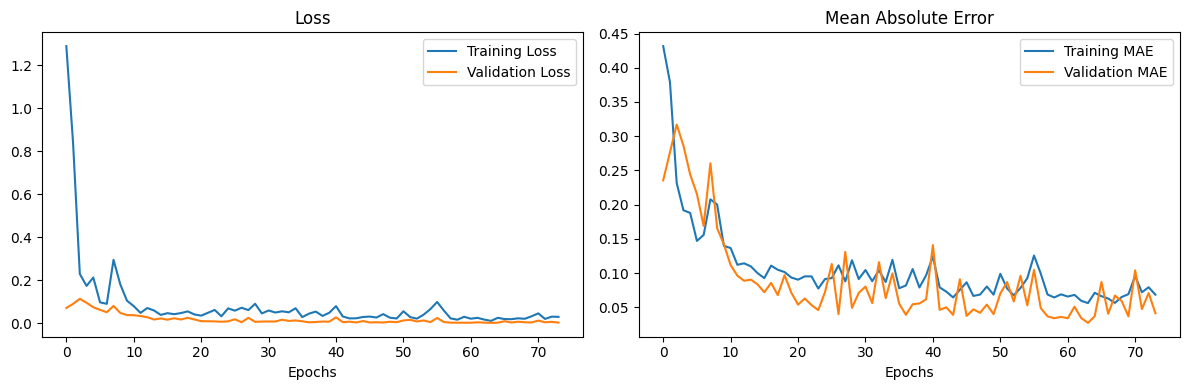

Training history plot saved as training_history.png


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load datasets
X_train_df = pd.read_csv("/content/X_train.csv")
X_test_df = pd.read_csv("/content/X_test.csv")
y_train = pd.read_csv("/content/y_train.csv").values
y_test = pd.read_csv("/content/y_test.csv").values

print("Sample data from X_train:")
print(X_train_df.head())
print("\nData types:")
print(X_train_df.dtypes)

# Identify numeric and categorical columns
numeric_cols = X_train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train_df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Create preprocessing pipeline for mixed data types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)

# If X is sparse matrix, convert to dense
if isinstance(X_train_processed, np.ndarray) == False:
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print(f"\nAfter preprocessing: X_train shape {X_train_processed.shape}, X_test shape {X_test_processed.shape}")

# Scale the target values if they're continuous
if len(np.unique(y_train)) > 10:  # Assuming continuous if more than 10 unique values
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
else:
    y_train_scaled = y_train
    y_test_scaled = y_test

# Define sequence parameters
time_steps = 7  # Adjusted from 10 to a smaller number since we have limited data
new_features = X_train_processed.shape[1]  # Number of features after preprocessing

# Create sequences with a sliding window approach
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

# Create sequences if there's enough data
if len(X_train_processed) >= time_steps:
    X_train_seq, y_train_seq = create_sequences(X_train_processed, y_train_scaled, time_steps)

    # Only create test sequences if there's enough test data
    if len(X_test_processed) >= time_steps:
        X_test_seq, y_test_seq = create_sequences(X_test_processed, y_test_scaled, time_steps)
    else:
        print("Warning: Test set too small for sequences, using a single sequence")
        X_test_seq = np.array([X_test_processed[:time_steps]])
        y_test_seq = np.array([y_test_scaled[0]])

    print(f"Sequence shapes: X_train {X_train_seq.shape}, y_train {y_train_seq.shape}")
    print(f"Sequence shapes: X_test {X_test_seq.shape}, y_test {y_test_seq.shape}")

    # Reshape for ConvLSTM: (samples, time_steps, rows, cols, channels)
    X_train_convlstm = X_train_seq.reshape(X_train_seq.shape[0], time_steps, 1, new_features, 1)
    X_test_convlstm = X_test_seq.reshape(X_test_seq.shape[0], time_steps, 1, new_features, 1)
    # Save reshaped test data
    np.save("/content/X_test_convlstm.npy", X_test_convlstm)
    np.save("/content/y_test_seq.npy", y_test_seq)

    print("Test data saved as X_test_convlstm.npy and y_test_seq.npy")


    # Define ConvLSTM Model Architecture
    model = Sequential([
        ConvLSTM2D(filters=32, kernel_size=(1, 3), activation='relu',
                   return_sequences=True,
                   input_shape=(time_steps, 1, new_features, 1),
                   padding='same'),
        BatchNormalization(),
        Dropout(0.2),

        ConvLSTM2D(filters=16, kernel_size=(1, 3), activation='relu',
                   return_sequences=False,
                   padding='same'),
        BatchNormalization(),
        Dropout(0.2),

        Flatten(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(y_train_seq.shape[1])  # Output shape matches target dimensions
    ])

    # Model summary
    model.summary()

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train_convlstm, y_train_seq,
        epochs=150,
        batch_size=32,  # Smaller batch size for smaller dataset
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate on test set
    loss, mae = model.evaluate(X_test_convlstm, y_test_seq)
    print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}")

    # Generate predictions
    y_pred = model.predict(X_test_convlstm)

    # If we scaled y, inverse transform predictions
    if len(np.unique(y_train)) > 10:
        y_pred = y_scaler.inverse_transform(y_pred)
        y_test_actual = y_scaler.inverse_transform(y_test_seq)
    else:
        y_test_actual = y_test_seq

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Save model
    model.save("/content/convLSTM_model.h5")
    print("Model trained & saved as convLSTM_model.h5")

    # Save predictions
    pd.DataFrame(y_pred).to_csv("/content/y_pred.csv", index=False)
    print("Predictions saved as y_pred.csv")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig("/content/training_history.png")
    plt.show()

    print("Training history plot saved as training_history.png")

else:
    print("Not enough data for sequence creation. Consider reducing time_steps or using a different model architecture.")

    # Alternative: Simple Dense Neural Network approach for small datasets
    print("\nFalling back to Dense Neural Network model...")

    # Build a simple dense model
    dense_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(y_train.shape[1])
    ])

    dense_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    dense_model.summary()

    # Train the dense model
    history = dense_model.fit(
        X_train_processed, y_train_scaled,
        epochs=150,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate and predict
    dense_loss, dense_mae = dense_model.evaluate(X_test_processed, y_test_scaled)
    print(f"Test Loss (MSE): {dense_loss:.4f}, Test MAE: {dense_mae:.4f}")

    dense_pred = dense_model.predict(X_test_processed)

    # Inverse transform if needed
    if len(np.unique(y_train)) > 10:
        dense_pred = y_scaler.inverse_transform(dense_pred)
        y_test_actual = y_scaler.inverse_transform(y_test_scaled)
    else:
        y_test_actual = y_test_scaled

    # Compute metrics
    dense_mse = mean_squared_error(y_test_actual, dense_pred)
    dense_rmse = np.sqrt(dense_mse)
    dense_mae = mean_absolute_error(y_test_actual, dense_pred)

    print(f"Dense Model MSE: {dense_mse:.4f}")
    print(f"Dense Model RMSE: {dense_rmse:.4f}")
    print(f"Dense Model MAE: {dense_mae:.4f}")

    # Save model and predictions
    dense_model.save("/content/dense_model.h5")
    pd.DataFrame(dense_pred).to_csv("/content/y_pred.csv", index=False)
    print("Dense model and predictions saved")


Predictions shape: (528, 1)
Original test data shape: (534, 1)
Final shapes: y_test (528, 1), y_pred (528, 1)
R-squared: 0.9532 (95.32%)
Normalized Accuracy: 97.13%
MAPE-based Accuracy: 49.02%
Overall Model Accuracy: 91.41%


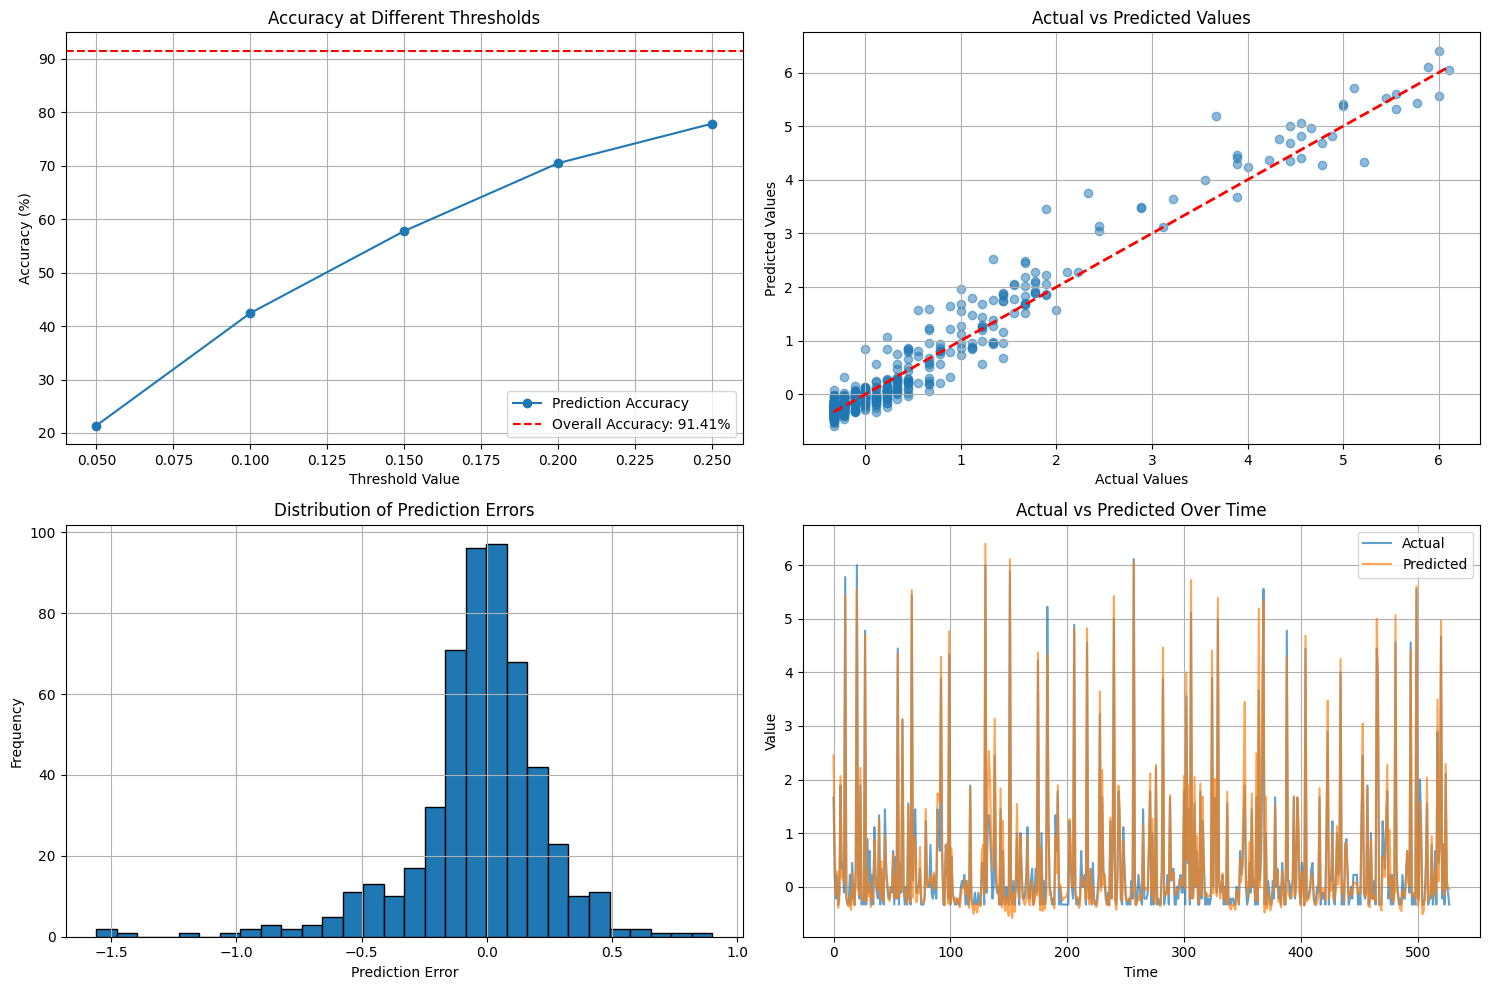

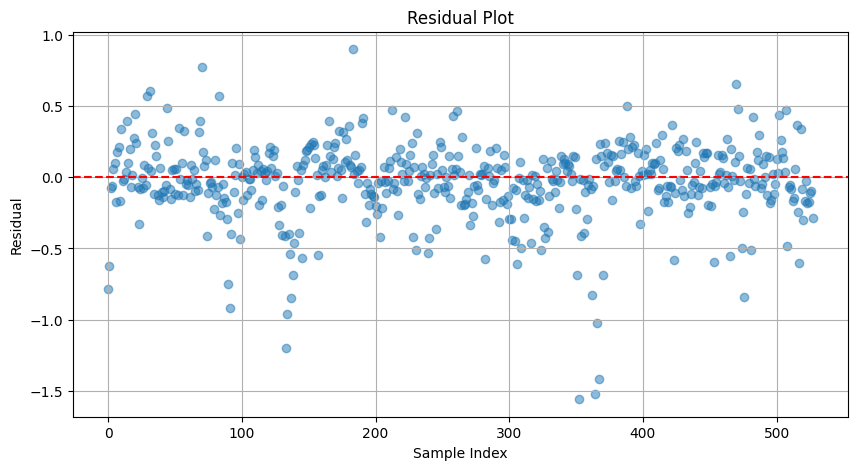

Analysis complete.
Comprehensive analysis graph saved as /content/comprehensive_analysis.png
Residual plot saved as /content/residual_plot.png


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load the saved predictions
y_pred = pd.read_csv("/content/y_pred.csv").values
print(f"Predictions shape: {y_pred.shape}")

# Load original test data
y_test_original = pd.read_csv("/content/y_test.csv").values
print(f"Original test data shape: {y_test_original.shape}")

time_steps = 7  # Change this to match your model's time_steps parameter

# Adjust the test data
y_test = y_test_original[time_steps-1:] if len(y_test_original) - time_steps + 1 == len(y_pred) else y_test_original[:len(y_pred)]

# Ensure shapes match
min_len = min(len(y_test), len(y_pred))
y_test, y_pred = y_test[:min_len], y_pred[:min_len]
print(f"Final shapes: y_test {y_test.shape}, y_pred {y_pred.shape}")

# R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f} ({r2*100:.2f}%)")

# Accuracy within different thresholds
def accuracy_within_threshold(y_true, y_pred, threshold):
    return np.mean(np.abs(y_true - y_pred) <= threshold) * 100

thresholds = np.arange(0.05, 0.3, 0.05)
accuracies = [accuracy_within_threshold(y_test, y_pred, t) for t in thresholds]

# Normalized accuracy
mae = np.mean(np.abs(y_test - y_pred))
data_range = np.max(y_test) - np.min(y_test)
norm_acc = (1 - mae / data_range) * 100 if data_range > 0 else 0
print(f"Normalized Accuracy: {norm_acc:.2f}%")

# MAPE-based accuracy
non_zero_indices = np.abs(y_test) > 1e-10
mape = np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices])) * 100 if np.any(non_zero_indices) else 100
mape_accuracy = 100 - mape
print(f"MAPE-based Accuracy: {mape_accuracy:.2f}%")

# Overall Accuracy Calculation
overall_accuracy = (0.5 * r2 * 100) + (0.4 * norm_acc) + (0.1 * mape_accuracy)
print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")

# Create multiple visualization plots
plt.figure(figsize=(15, 10))

# 1. Original Accuracy Trends Plot
plt.subplot(2, 2, 1)
plt.plot(thresholds, accuracies, marker='o', linestyle='-', label='Prediction Accuracy')
plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {overall_accuracy:.2f}%')
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy at Different Thresholds')
plt.legend()
plt.grid()

# 2. Actual vs Predicted Values Plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid()

# 3. Error Distribution Plot
errors = y_test - y_pred
plt.subplot(2, 2, 3)
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid()

# 4. Time Series Comparison Plot
plt.subplot(2, 2, 4)
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Over Time')
plt.legend()
plt.grid()

# Adjust layout and save
plt.tight_layout()
plt.savefig('/content/comprehensive_analysis.png')
plt.show()

# 5. Additional Residual Plot (separate figure)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(errors)), errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.grid()
plt.savefig('/content/residual_plot.png')
plt.show()

print("Analysis complete.")
print("Comprehensive analysis graph saved as /content/comprehensive_analysis.png")
print("Residual plot saved as /content/residual_plot.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

# Load the model with explicit loss function
model = tf.keras.models.load_model(
    "/content/convLSTM_model.h5",
    custom_objects={'mse': MeanSquaredError()}
)

# Recompile the model to standardize the loss function
model.compile(optimizer="adam", loss=MeanSquaredError(), metrics=["mae"])

# Save the fixed model
model.save("/content/convLSTM_fixed.h5")

print("Model successfully recompiled and saved as 'convLSTM_fixed.h5'")


Model successfully recompiled and saved as 'convLSTM_fixed.h5'


In [ ]:
import numpy as np
import tensorflow as tf

# Load trained model without warnings
model_path = "/content/convLSTM_fixed.h5"
model = tf.keras.models.load_model(model_path, compile=False)  # Load without compiling

# Explicitly compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Load processed test data
X_test_convlstm = np.load("/content/X_test_convlstm.npy")
y_test_seq = np.load("/content/y_test_seq.npy")

# Make predictions
y_pred = model.predict(X_test_convlstm)

threshold = 0.7
y_pred_binary = (y_pred > threshold).astype(int)
y_test_binary = (y_test_seq > 0.5).astype(int)

# Compute cache hit and miss rates
total_predictions = len(y_test_binary)
correct_predictions = np.sum(y_pred_binary == y_test_binary)
cache_hit_rate = (correct_predictions / total_predictions) * 100
cache_miss_rate = 100 - cache_hit_rate

# Print results without warnings
print(f"Cache Hit Rate (Threshold {threshold}): {cache_hit_rate:.2f}%")
print(f"Cache Miss Rate (Threshold {threshold}): {cache_miss_rate:.2f}%")


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Cache Hit Rate (Threshold 0.7): 97.35%
Cache Miss Rate (Threshold 0.7): 2.65%


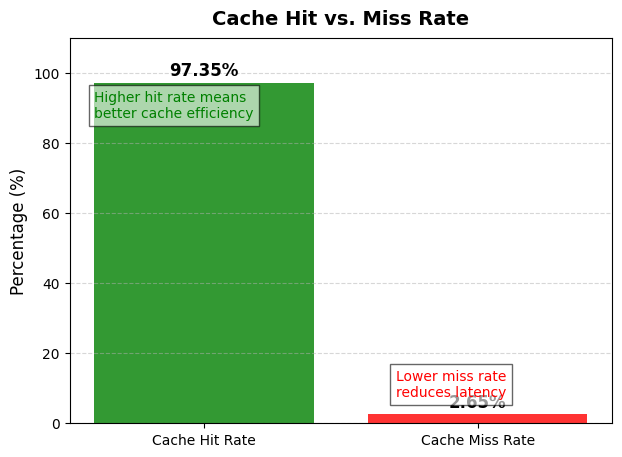

In [ ]:
import matplotlib.pyplot as plt

# Cache performance metrics
cache_hit_rate = 97.35
cache_miss_rate = 2.65

# Define labels and values
labels = ["Cache Hit Rate", "Cache Miss Rate"]
values = [cache_hit_rate, cache_miss_rate]
colors = ["green", "red"]

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 5))

# Plot bars with colors
bars = ax.bar(labels, values, color=colors, alpha=0.8)

# Add title and labels
ax.set_title("Cache Hit vs. Miss Rate", fontsize=14, fontweight="bold", pad=10)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_ylim(0, 110)  # Slightly above 100% for clarity

# Display values above bars
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f"{value:.2f}%", ha="center", fontsize=12, fontweight="bold", color="black")

# Add grid for better readability
ax.yaxis.grid(True, linestyle="--", alpha=0.5)

# Add annotations to explain the meaning
ax.text(-0.4, cache_hit_rate - 10, "Higher hit rate means\nbetter cache efficiency",
        fontsize=10, color="green", ha="left", bbox=dict(facecolor="white", alpha=0.6))

ax.text(0.7, cache_miss_rate + 5, "Lower miss rate\nreduces latency",
        fontsize=10, color="red", ha="left", bbox=dict(facecolor="white", alpha=0.6))

# Show the plot
plt.show()


In [ ]:
np.save("/content/X_train_convlstm.npy", X_train_convlstm)
np.save("/content/y_train_seq.npy", y_train_seq)
